In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model, model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import RFECV
%matplotlib inline

I wanted to put together a brief example of how various data science techniques can be applied towards Out of the Park Baseball 20. This guide should be seen as a very basic overview without getting into a lot of the technical aspects of the field, and is not an exhautive look at building a model.

##### The Setup
- Created a New Standard Game in OOTP20 using the default rosters as the game shipped with. All players had injuries and fatigue reset. The rosters were exapanded to 40 players, and then the AI was used to setup every roster. All park effects were set to 1.000 to remove the impact of stadiums on the outcome.
- The simulation model was used to simulate every team against every other team in the league a total of 1,620 (10 seasons), with every team ultimately playing 46,980 games. 
- Each matchup generates a simulation report that is saved as a temporary HTML document. My script that automates this watches for this report to get modified, and then scrapes the HTML for the relevant statistics.
- Once the script was completed, a CSV dump was done of the game that included the players, and players_batting tables the game generates.
- [An example of the script working can be seen in this video.](https://www.youtube.com/watch?v=wqQe92LvWPg) Note this is just looking at one team versus the rest of the league, and is only using 162 games.

Why use the simulation module over just simulating a season -or more - in the game and using those results? The inherent variability in baseball statistics would lead to a poorer model, and there are too many other factors (injuries, rating changes throughout the season, small sample sizes) that make it an inferior method. Automating the data collection process through the simulation module - while having access to limited stats - is the far superior method since it can generate tens of thousands of seasons of stats relatively quickly.

In this first cell, I'm just loading the stats from the simulation engine and then dropping any players that did not accumulate 25,000 at-bats during the process, and then using only the wOBA column since that is what I am going to be building a model to predict.

In [2]:
bat_stats = pd.read_csv('player_sim_batting_stats.csv', index_col='player_id')
bat_stats = bat_stats.loc[bat_stats['AB'] > 25000, ['wOBA']]
bat_stats.head()

,wOBA
player_id,
12,0.3374
15,0.3353
16,0.3647
31,0.3184
47,0.2885


In this cell I am loading in the players_batting CSV file and then selecting only the ratings that I will be using in the analysis, which are the current batting ratings versus left and right-handed pitchers, and the batted ball profile for ground and flyballs. 

One could simplify it by looking at the current overall batting ratings without breaking it down by splits. Since Potential numbers are not generated at a split level, if I were trying to gauge how well a batter could be in the future, using the current overall ratings would be the only option.

In [3]:
bat_ratings = pd.read_csv('players_batting.csv', index_col='player_id')
bat_ratings = bat_ratings.iloc[:, [11, 12, 13, 14, 16, 18, 19, 20, 21, 23,34 ,35]]
bat_ratings.head()

,batting_ratings_vsr_contact,batting_ratings_vsr_gap,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_vsr_power,batting_ratings_vsl_contact,batting_ratings_vsl_gap,batting_ratings_vsl_eye,batting_ratings_vsl_strikeouts,batting_ratings_vsl_power,batting_ratings_misc_gb_hitter_type,batting_ratings_misc_fb_hitter_type
player_id,,,,,,,,,,,,
1,45,44,55,24,40,40,39,49,22,33,2,2
2,106,71,103,145,56,96,68,93,137,53,1,1
3,44,41,41,25,10,41,37,37,23,9,2,2
4,59,64,67,40,48,57,62,64,38,46,0,0
5,25,74,27,14,5,28,76,30,15,5,1,1


The players CSV file contains a lot of biographical data about each player in the game. The only columns I am concerned with from this is the handedness of each player and their relevant running attributes.

In [4]:
player_run = pd.read_csv('players.csv', index_col='player_id')
player_run = player_run.loc[:, ['bats', 'running_ratings_speed', 'running_ratings_stealing', 'running_ratings_baserunning']]
player_run.head()

c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,bats,running_ratings_speed,running_ratings_stealing,running_ratings_baserunning
player_id,,,,
1,2,76,66,85
2,1,95,66,92
3,2,15,10,30
4,2,119,111,105
5,1,89,33,77


With the three relevant data frames loaded into the notebook, it's time to merge them together on the player_id index, which results in a total of 384 observations.

In [5]:
df = bat_stats.join(bat_ratings).join(player_run)
df.head()

,wOBA,batting_ratings_vsr_contact,batting_ratings_vsr_gap,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_vsr_power,batting_ratings_vsl_contact,batting_ratings_vsl_gap,batting_ratings_vsl_eye,batting_ratings_vsl_strikeouts,batting_ratings_vsl_power,batting_ratings_misc_gb_hitter_type,batting_ratings_misc_fb_hitter_type,bats,running_ratings_speed,running_ratings_stealing,running_ratings_baserunning
player_id,,,,,,,,,,,,,,,,,
12,0.3374,92,88,144,31,178,82,87,142,25,150,3,3,2,65,73,106
15,0.3353,119,138,100,89,115,116,118,107,96,92,2,2,1,188,185,176
16,0.3647,112,123,141,59,162,90,98,112,45,127,2,2,2,108,67,122
31,0.3184,96,111,99,56,126,101,116,103,60,133,2,2,1,53,89,88
47,0.2885,81,101,119,50,95,86,105,121,51,107,2,2,1,34,55,95


The players batted ball profiles, and handedness are all categorical varibles, but are stored and treated currently as integers. This process just converts them into a way the learning methods can better handle them.

In [6]:
df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']] = df[['bats', 'batting_ratings_misc_gb_hitter_type', 'batting_ratings_misc_fb_hitter_type']].astype('category')
df = pd.get_dummies(df)
df.dtypes

wOBA                                     float64
batting_ratings_vsr_contact                int64
batting_ratings_vsr_gap                    int64
batting_ratings_vsr_eye                    int64
batting_ratings_vsr_strikeouts             int64
batting_ratings_vsr_power                  int64
batting_ratings_vsl_contact                int64
batting_ratings_vsl_gap                    int64
batting_ratings_vsl_eye                    int64
batting_ratings_vsl_strikeouts             int64
batting_ratings_vsl_power                  int64
running_ratings_speed                      int64
running_ratings_stealing                   int64
running_ratings_baserunning                int64
batting_ratings_misc_gb_hitter_type_0      uint8
batting_ratings_misc_gb_hitter_type_1      uint8
batting_ratings_misc_gb_hitter_type_2      uint8
batting_ratings_misc_gb_hitter_type_3      uint8
batting_ratings_misc_fb_hitter_type_0      uint8
batting_ratings_misc_fb_hitter_type_1      uint8
batting_ratings_misc

I learned about the pandas_profiling report this week and included it beacause I think it's a neat way to do a lot of exploratory data analysis rather quickly. The report suggests that one of the strikeout ratings should be removed since they're both highly correlated - apparently if you are good at not striking out against righties, you're also good at not striking out against lefties - but we'll leave it in for the time being.

In [7]:
pp.ProfileReport(df)

In this next cell I am just separating the target variable - wOBA - from the variables we'll be using to predict a player's wOBA.

In [8]:
target = df['wOBA']
variables = df.drop(['wOBA'], axis=1)

This exercise is just going to focus on a simple Linear Regression model. There are other linear models that could be applied, but honestly this model has really good results with out dataset already. 

Typically when working with machine learning methods, you'll break-up your data into a training set and a validation set. A model will be built of the training set, and then tested against the validation set to verify how well it performs on data it hasn't seen. In the below cell I am using the first 80 percent of the data to train the model and then testing it on the remaining players. Mean Squared Error is standard testing measurement on linear models.

In [9]:
lr = linear_model.LinearRegression()
lr.fit(variables[ :308], target[ :308])
print('The model has a MSE of {0:8f}'.format(mean_squared_error(lr.predict(variables[308: ]), target[308: ])))

The model has a MSE of 0.000050


The next two cells just contain standard plots to inspect whether a model is biased in it's predictions. There's nothing evident in either that would suggest there is bias in the model or would require us to perform some transformations on our data.

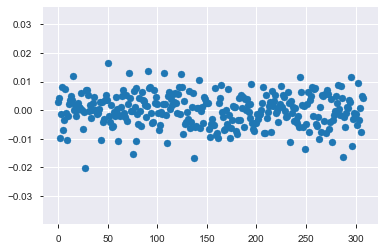

In [10]:
residuals = lr.predict(variables[ :308]) - target[ :308]
residuals = residuals.reset_index()['wOBA']
plt.scatter(residuals.index, residuals)
plt.show()

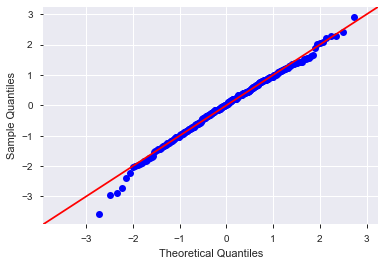

In [11]:
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

Normally when creating a testing and validation set, you would choose observations at random, which I did not do. Another way of creating a testing/validation sets is to use cross-validation because it's possible that a model could do really well on the single validation set through random chance. In the below cell the process of using 10-fold cross-vlaidation is uses which is essentially splitting the data into 10 different sets, training the model on nine, and then testing it on the set that was left out. This process repeats 10 times until all sets have been used to validate the model once.

In [12]:
lr_results = model_selection.cross_validate(lr, variables, target, cv=10, scoring=make_scorer(mean_squared_error, greater_is_better=False))

print('The model has a MSE of {0:8f}'.format(np.mean(lr_results['test_score'])))

The model has a MSE of -0.000040


We could run with the model that has been made already, but the pandas_profiling report suggested we remove one of the strikeout ratings because it was highly correlated with the other. Rather than do that right off the bat, we can do some feature selection to identify which variables can be removed to produce the best model possible. This next cell does just that, by doing that 10-fold cross-validation process with the entire dataset, then removes the variable that is least important, and then repeats. In the output, we can see process recommends the three running attributes be removed, along with gb_hitter_type_1 - which I believe is spray ball hitters. Moving forward, I will just remove the three running attributes.

In [13]:
selector = RFECV(lr, step=1, cv=10, scoring=make_scorer(mean_squared_error, greater_is_better=False))
selector = selector.fit(variables, target)

dict(zip(variables.columns, selector.ranking_))

{'batting_ratings_vsr_contact': 1,
 'batting_ratings_vsr_gap': 1,
 'batting_ratings_vsr_eye': 1,
 'batting_ratings_vsr_strikeouts': 1,
 'batting_ratings_vsr_power': 1,
 'batting_ratings_vsl_contact': 1,
 'batting_ratings_vsl_gap': 1,
 'batting_ratings_vsl_eye': 1,
 'batting_ratings_vsl_strikeouts': 1,
 'batting_ratings_vsl_power': 1,
 'running_ratings_speed': 4,
 'running_ratings_stealing': 5,
 'running_ratings_baserunning': 3,
 'batting_ratings_misc_gb_hitter_type_0': 1,
 'batting_ratings_misc_gb_hitter_type_1': 2,
 'batting_ratings_misc_gb_hitter_type_2': 1,
 'batting_ratings_misc_gb_hitter_type_3': 1,
 'batting_ratings_misc_fb_hitter_type_0': 1,
 'batting_ratings_misc_fb_hitter_type_1': 1,
 'batting_ratings_misc_fb_hitter_type_2': 1,
 'batting_ratings_misc_fb_hitter_type_3': 1,
 'bats_1': 1,
 'bats_2': 1,
 'bats_3': 1}

In [14]:
variables.drop(columns=['running_ratings_speed', 'running_ratings_stealing',
       'running_ratings_baserunning'], inplace=True)

lr_results = model_selection.cross_validate(lr, variables, target, cv=10, scoring=make_scorer(mean_squared_error, greater_is_better=False))

print('The model has a MSE of {0:8f}'.format(np.mean(lr_results['test_score'])))

The model has a MSE of -0.000040


I feel pretty happy with where things are, so the next cell is just creating the linear regression model on the entire dataset. The coeficients from each variable can be inspected. In the cell below, the maximum normal attribute in the game - 200 - is used to better describe the overall impact each attribute has in estimating wOBA, with the ability to get contact against RHP being the biggest indicator.

In [15]:
lr.fit(variables, target)
dict(zip(variables.columns, lr.coef_))

{'batting_ratings_vsr_contact': 0.0006797183607761599,
 'batting_ratings_vsr_gap': 0.0001519010334107514,
 'batting_ratings_vsr_eye': 0.0002810991245652555,
 'batting_ratings_vsr_strikeouts': 1.5939190217874927e-05,
 'batting_ratings_vsr_power': 0.0002583960664101439,
 'batting_ratings_vsl_contact': 0.000321380449712557,
 'batting_ratings_vsl_gap': 6.0421967388732796e-05,
 'batting_ratings_vsl_eye': 9.983219306220163e-05,
 'batting_ratings_vsl_strikeouts': 3.0109285067797776e-05,
 'batting_ratings_vsl_power': 0.00010146458417178167,
 'batting_ratings_misc_gb_hitter_type_0': -0.0005730984253876705,
 'batting_ratings_misc_gb_hitter_type_1': -1.2441504933631172e-05,
 'batting_ratings_misc_gb_hitter_type_2': -0.000522032831960126,
 'batting_ratings_misc_gb_hitter_type_3': 0.001107572762281426,
 'batting_ratings_misc_fb_hitter_type_0': -0.0008781112186666922,
 'batting_ratings_misc_fb_hitter_type_1': 0.0012456096919599812,
 'batting_ratings_misc_fb_hitter_type_2': 0.0002355947890546784,
 'b

In [16]:
dict(zip(variables.columns[0:10], lr.coef_[0:10] * 200))

{'batting_ratings_vsr_contact': 0.13594367215523198,
 'batting_ratings_vsr_gap': 0.03038020668215028,
 'batting_ratings_vsr_eye': 0.0562198249130511,
 'batting_ratings_vsr_strikeouts': 0.0031878380435749853,
 'batting_ratings_vsr_power': 0.051679213282028784,
 'batting_ratings_vsl_contact': 0.0642760899425114,
 'batting_ratings_vsl_gap': 0.01208439347774656,
 'batting_ratings_vsl_eye': 0.019966438612440327,
 'batting_ratings_vsl_strikeouts': 0.006021857013559556,
 'batting_ratings_vsl_power': 0.020292916834356335}

Having a model is one thing, but the whole point was being able to use it on players the model hasn't seen in order to gauage how well the would do. In the next two cells, five players are created and displayed:

- A light power, high-contact/high-eye player
- A doubles machine with average power, who also doesn't strike out a bunch
- An all-around above average hitter
- A switch-hitter with above average ratings
- A 'power'-hitter who will strike-out a ton

In [17]:
new_players = [[138, 95, 128, 157, 54, 129, 91, 124, 150, 50, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
               [154, 184, 88, 147, 140, 156, 189, 91, 148, 144, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
               [147, 136, 112, 85, 133, 168, 109, 135, 105, 150, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
               [134, 127, 131, 84, 153, 142, 135, 129, 87, 161, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
               [94, 122, 95, 49, 138, 107, 129, 105, 56, 158, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]]
               
list_players = []
for player in new_players:
    list_players.append(dict(zip(variables.columns, player)))
               
new_player = pd.DataFrame(new_players)
new_player.columns = variables.columns
new_player

,batting_ratings_vsr_contact,batting_ratings_vsr_gap,batting_ratings_vsr_eye,batting_ratings_vsr_strikeouts,batting_ratings_vsr_power,batting_ratings_vsl_contact,batting_ratings_vsl_gap,batting_ratings_vsl_eye,batting_ratings_vsl_strikeouts,batting_ratings_vsl_power,...,batting_ratings_misc_gb_hitter_type_1,batting_ratings_misc_gb_hitter_type_2,batting_ratings_misc_gb_hitter_type_3,batting_ratings_misc_fb_hitter_type_0,batting_ratings_misc_fb_hitter_type_1,batting_ratings_misc_fb_hitter_type_2,batting_ratings_misc_fb_hitter_type_3,bats_1,bats_2,bats_3
0,138,95,128,157,54,129,91,124,150,50,...,1,0,0,1,0,0,0,0,1,0
1,154,184,88,147,140,156,189,91,148,144,...,0,0,0,1,0,0,0,1,0,0
2,147,136,112,85,133,168,109,135,105,150,...,1,0,0,1,0,0,0,1,0,0
3,134,127,131,84,153,142,135,129,87,161,...,0,1,0,0,1,0,0,0,0,1
4,94,122,95,49,138,107,129,105,56,158,...,0,0,1,0,1,0,0,1,0,0


The next cell just produces a wOBA prediction for each player.

In [18]:
lr.predict(new_player)

array([0.34477821, 0.39309897, 0.38828924, 0.39322386, 0.3272664 ])

##### Next steps
The rating scale used in this was 0-200, so if access to that scale isn't available (online leagues like TGS for example) then you would need to do some conversion from whatever scale the league you are in uses to be able to utilize such a model. Note, I didn't include the intercept when printing the coeficients, so using the numbers above will likely result in wOBA estimates that don't "feel" right because there isn't that constant being appliedto bring them onto the same scale.

The below cell just converts a 60 that is on the 20-80 scale to one that fits the 200-1 scale. This is pretty close to what the first new batter's contact (60 in game, 138 in the database) would convert to.

In [19]:
#Converting a 60 on 80-20 scale to 200-1 scale
print((((60 - 20) * (200 - 1)) / (80 - 20)) + 1)

#Converting a 60 on the 200-1 scale to the 80-20 scale
print((((138 - 1) * (80 - 20)) / (200 - 1)) + 20)

133.66666666666666
61.30653266331658
